In [2]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
#Tensorflow libs
import tensorflow as tf
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split
import random
import cv2
from PIL import Image


In [3]:
# Defining training and testing directories
base_dir = './fruits/'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [4]:
# Checking if the training directory exists
if not os.path.exists(base_dir):
    raise Exception(f"Base directory {base_dir} does not exist.")
elif not os.path.exists(train_dir):
    raise Exception(f"Training directory {train_dir} does not exist.")
elif not os.path.exists(test_dir):
    raise Exception(f"Testing directory {test_dir} does not exist.")
else:
    print("All directories exist.")

All directories exist.


In [5]:
# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Using GPU: {gpus}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("No GPU found, using CPU.")

No GPU found, using CPU.


In [6]:
# Iterate through subdirectories of the training directory to check for corrupted images
for subdir in os.listdir(train_dir):
    subdir_path = os.path.join(train_dir, subdir)
    
    if not os.path.isdir(subdir_path):  # Skip if not a directory
        continue

    image_count = 0  # Track valid images

    # Iterate files in the subdirectory
    for filename in os.listdir(subdir_path):
        file_path = os.path.join(subdir_path, filename)

        # Check if the file is an image
        if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            print(f"Skipping {file_path} due to invalid file extension")
            continue

        # Check if the image is corrupted or has transparency issues
        try:
            with Image.open(file_path) as img:
                # Handle transparent images
                if img.mode == 'RGBA':
                    img = img.convert('RGB')
                    img.save(file_path)  # Save after conversion

                img.verify()  # Verify image integrity

            image_count += 1  # Increase count for valid images

        except (IOError, SyntaxError) as e:
            print(f"Deleting corrupted file {file_path}: {e}")
            os.remove(file_path)

    # Print the number of valid images in each class directory
    print(f"Number of valid images in {subdir}: {image_count}")


Number of valid images in apple: 1380
Number of valid images in avocado: 1312
Number of valid images in banana: 1387
Number of valid images in blueberry: 1312
Number of valid images in cherry: 1312
Number of valid images in dragonfruit: 1301
Number of valid images in grape: 1412
Number of valid images in guava: 1312
Number of valid images in kiwi: 1399
Number of valid images in lychee: 1312
Number of valid images in mango: 1398
Number of valid images in orange: 1381
Number of valid images in papaya: 1312
Number of valid images in pear: 1401
Number of valid images in pineapple: 1411
Number of valid images in pomegranate: 1391
Number of valid images in raspberry: 1312
Number of valid images in strawberry: 1312
Number of valid images in watermelon: 1396


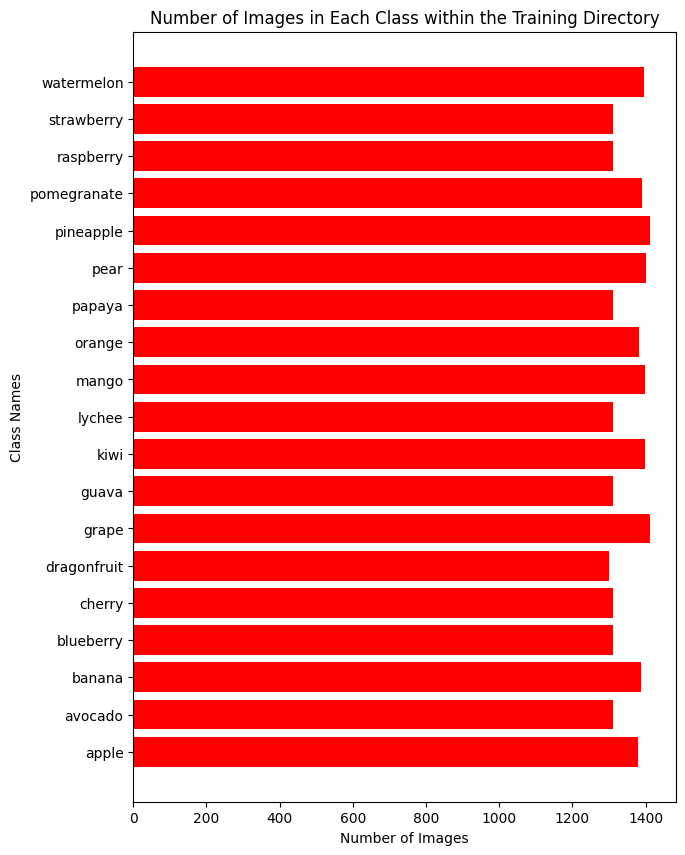

In [7]:
# Count the number of images in each class within the training directory
class_counts = {}
for subdir in os.listdir(train_dir):
	subdir_path = os.path.join(train_dir, subdir)
	if os.path.isdir(subdir_path):
		num_images = len([name for name in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, name))])
		class_counts[subdir] = num_images

# Extract class names and their corresponding image counts
class_names = sorted(list(class_counts.keys()))
image_counts = list(class_counts.values())

# Create a bar chart
plt.figure(figsize=(7, 10))
plt.barh(class_names, image_counts, color='red')
plt.xlabel('Number of Images')
plt.ylabel('Class Names')
plt.title('Number of Images in Each Class within the Training Directory')
plt.show()

In [8]:
BATCH_SIZE = 32
IMAGE_SIZE = 100
CHANNELS = 3

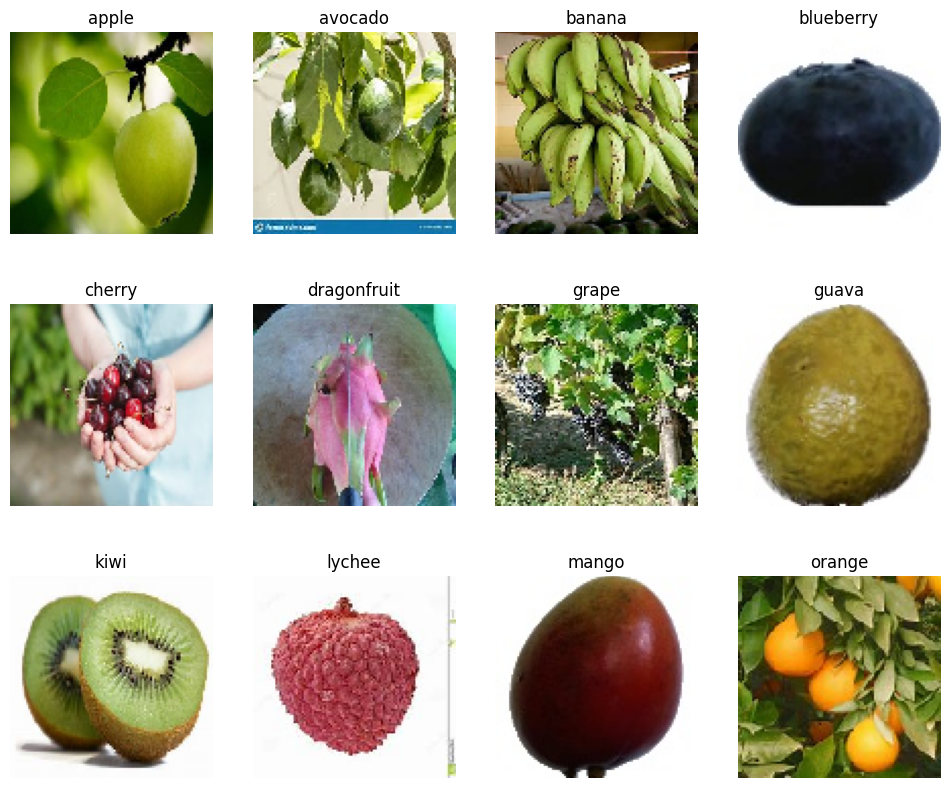

In [9]:
plt.figure(figsize=(12, 10))
classes = os.listdir(train_dir)[:12]  # Limit to 12 classes
for i, class_name in enumerate(classes):
    class_dir = os.path.join(train_dir, class_name)
    file_name = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][0]
    img_path = os.path.join(class_dir, file_name)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.show()

In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    fill_mode='nearest'
)


train_dataset = train_generator.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

Found 25753 images belonging to 19 classes.


In [11]:
val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Specify the validation split
)

val_dataset = val_generator.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',  # Specify the subset as validation
)

Found 5144 images belonging to 19 classes.


In [12]:
# Load existing model
# If model is not available, create a new model
if os.path.exists('fruits_classification.keras'):
    model = tf.keras.models.load_model('fruits_classification.keras')
    print("Model loaded.")
else:
    # Model architecture 
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.25),

        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])

Model loaded.


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 19)             │         9,747 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,971,323 (76.18 MB)

 Trainable params: 6,657,107 (25.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,314,216 (50.79 MB)

In [14]:
# Calculate steps per epoch and validation steps

steps_per_epoch = train_dataset.samples // train_dataset.batch_size
validation_steps = val_dataset.samples // val_dataset.batch_size

steps_per_epoch, validation_steps

(804, 160)

In [15]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('fruits_classification.keras', save_best_only=True)
earlyStopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
reduceLearningRate = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

In [16]:
# Compiling the model using the Adam optimizer and categorical cross entropy-loss function
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), optimizer=tf.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.Precision()])

# Training the model using the CallbackAcc object and storing the history of the model
history = model.fit(
    train_dataset, # Train the model on the augmented training images
    steps_per_epoch=steps_per_epoch,   # Number of steps (batches) to yield from the generator at each epoch
    validation_steps=validation_steps,   # Number of steps (batches) to yield from the generator at each epoch
    epochs=10,    # Number of epochs to train the model
    validation_data=val_dataset,    # Validate the model on the augmented validation images
    verbose=1,    # Verbosity mode (0 = silent, 1 = progress bar, 2 = one line per epoch)
    callbacks=[checkpoint, earlyStopping, reduceLearningRate]    # Callback function to stop training if accuracy is greater than or equal to 99%
)


Epoch 1/10


e:\pythonproject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


117/804 ━━━━━━━━━━━━━━━━━━━━ 1:49 160ms/step - accuracy: 0.9357 - loss: 0.8810 - precision: 0.9716

e:\pythonproject\.venv\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


804/804 ━━━━━━━━━━━━━━━━━━━━ 147s 180ms/step - accuracy: 0.9365 - loss: 0.8710 - precision: 0.9794 - val_accuracy: 0.9822 - val_loss: 0.7302 - val_precision: 0.9962 - learning_rate: 1.0000e-04
Epoch 2/10
  1/804 ━━━━━━━━━━━━━━━━━━━━ 2:11 164ms/step - accuracy: 0.9375 - loss: 0.8256 - precision: 1.0000

e:\pythonproject\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


804/804 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9375 - loss: 0.8256 - precision: 1.0000 - val_accuracy: 0.9828 - val_loss: 0.7306 - val_precision: 0.9962 - learning_rate: 1.0000e-04
Epoch 3/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 152s 189ms/step - accuracy: 0.9417 - loss: 0.8612 - precision: 0.9827 - val_accuracy: 0.9873 - val_loss: 0.7174 - val_precision: 0.9975 - learning_rate: 1.0000e-04
Epoch 4/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8750 - loss: 0.9957 - precision: 0.9615 - val_accuracy: 0.9867 - val_loss: 0.7161 - val_precision: 0.9975 - learning_rate: 1.0000e-04
Epoch 5/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 149s 184ms/step - accuracy: 0.9532 - loss: 0.8393 - precision: 0.9867 - val_accuracy: 0.9904 - val_loss: 0.7041 - val_precision: 0.9973 - learning_rate: 1.0000e-04
Epoch 6/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8750 - loss: 1.0306 - precision: 1.0000 - val_accuracy: 0.9908 - val_loss: 0.7035 - val_precision: 0.9973 - learning_rate: 1.0000e-0

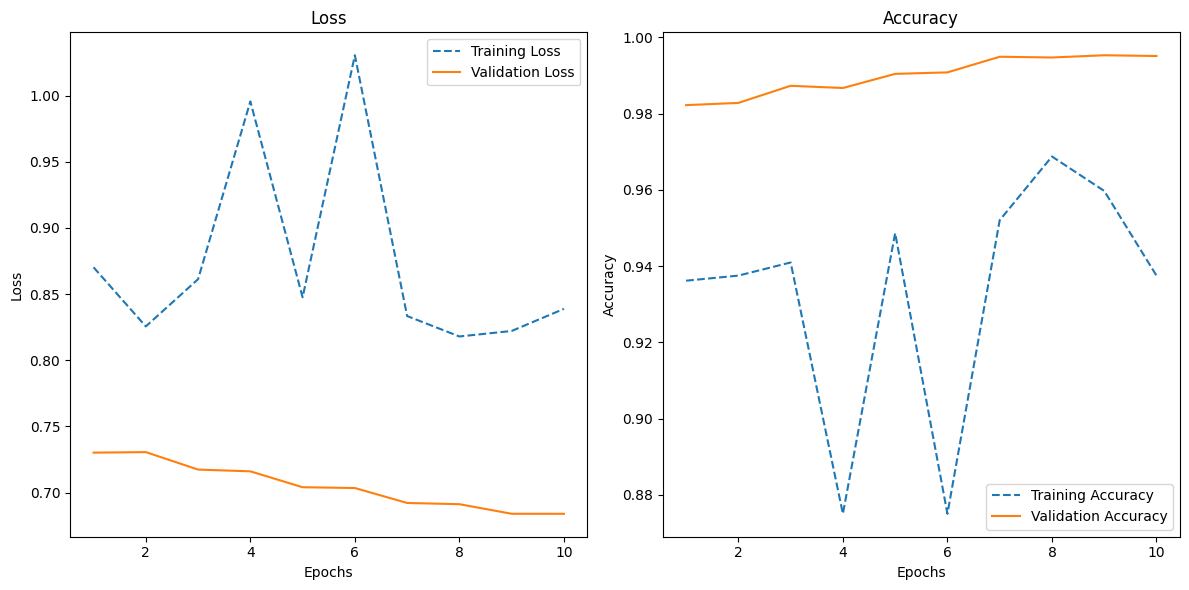

In [17]:
# Plotting loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', linestyle='dashed')   
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy', linestyle='dashed')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
def load_test_images_structured(directory, target_size=(IMAGE_SIZE, IMAGE_SIZE)):
    images = []  # Initialize an empty list to store images
    labels = []  # Initialize an empty list to store labels
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]  # Get all subdirectories in the directory
    for class_dir in class_dirs:  # Iterate over each class directory
        class_path = os.path.join(directory, class_dir)  # Get the full path of the class directory
        for filename in os.listdir(class_path):  # Iterate over each file in the class directory
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):  # Check if the file is an image
                img_path = os.path.join(class_path, filename)  # Get the full path of the image file
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)  # Load the image with the specified target size
                img_array = tf.keras.preprocessing.image.img_to_array(img)  # Convert the image to an array
                img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to create a batch axis
                images.append(img_array)  # Append the image array to the images list
                labels.append(class_dir)  # Append the class label to the labels list
    return np.vstack(images), labels  # Return the stacked images and labels

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step
Class Indices from Training: ['apple', 'avocado', 'banana', 'blueberry', 'cherry', 'dragonfruit', 'grape', 'guava', 'kiwi', 'lychee', 'mango', 'orange', 'papaya', 'pear', 'pineapple', 'pomegranate', 'raspberry', 'strawberry', 'watermelon']
              precision    recall  f1-score   support

           0       0.78      0.56      0.65      1056
           1       0.78      0.84      0.81       494
           2       0.81      0.69      0.75       625
           3       0.87      0.92      0.90       354
           4       0.85      0.72      0.78       820
           5       0.64      0.81      0.72       207
           6       0.91      0.76      0.83       908
           7       0.73      0.85      0.78       370
           8       0.79      0.84      0.81       358
           9       0.72      0.83      0.77       367
          10       0.67      0.82      0.74       494
          11       0.85      0.94      0.89       324
          12   

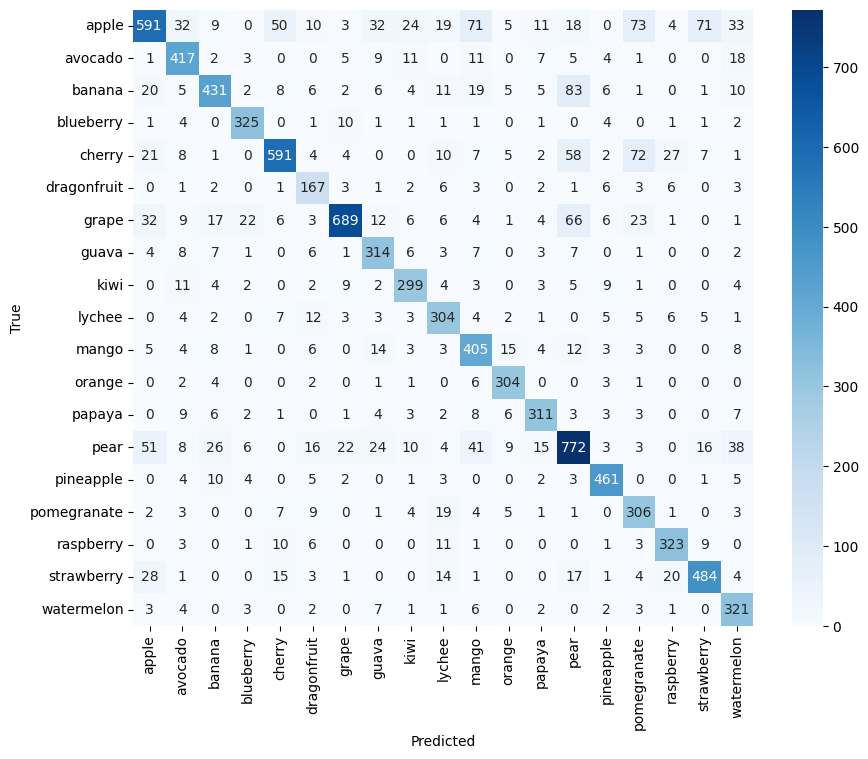

In [19]:

test_images, test_labels = load_test_images_structured(test_dir)

# Normalize the test images
test_images = test_images / 255.0

# Predict the classes of the test images
predictions = model.predict(test_images)

# Get the predicted class indices
predicted_classes = np.argmax(predictions, axis=1)

# Print the class indices from training
print("Class Indices from Training:", class_names)

# Adjust test labels to lowercase
adjusted_test_labels = [label.lower() for label in test_labels]

# Create a label map from class names to indices
label_map = {name.lower(): idx for idx, name in enumerate(class_names)}

# Map true class labels to their corresponding indices
true_classes = [label_map[label] for label in adjusted_test_labels]

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes, labels=list(label_map.values()))

# Print the classification report
print(classification_report(true_classes, predicted_classes, labels=list(label_map.values()), zero_division=0))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [20]:
# Prediction function
def predict_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(100, 100))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale
    
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction)
    
    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


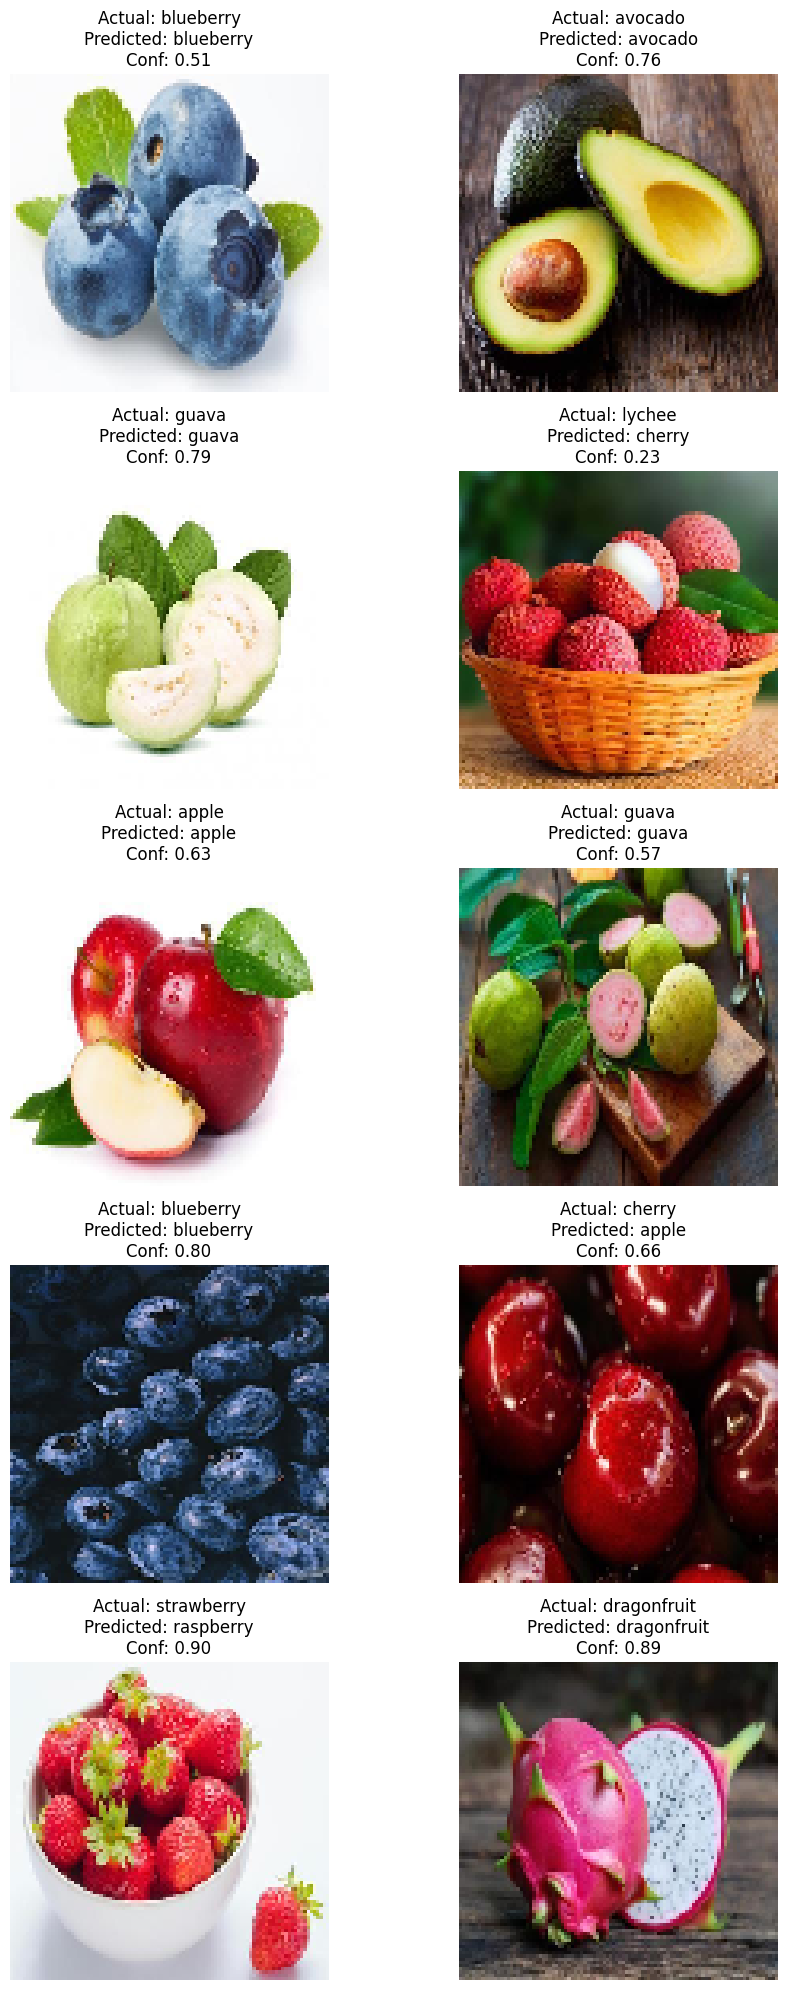

In [21]:
#get random 10 images from dir
random_images = random.sample(os.listdir('./fruits/predict/'), 10)
actual_labels = [img.split('_')[0] for img in random_images]
plt.figure(figsize=(10, 20))
for i, img in enumerate(random_images):
    img_path = os.path.join('./fruits/predict/', img)
    predicted_class, confidence = predict_image(img_path)
    plt.subplot(5, 2, i + 1)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    plt.imshow(img)
    plt.title(f"Actual: {actual_labels[i]}\nPredicted: {predicted_class}\nConf: {confidence:.2f}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [22]:
color_according_to_fruit = {
    "apple": (0, 0, 255),       # Red
    "avocado": (0, 255, 0),     # Green
    "banana": (0, 255, 255),    # Yellow
    "blueberry": (255, 0, 0),   # Blue
    "cherry": (0, 0, 255),      # Red
    "grape": (128, 0, 128),     # Purple
    "kiwi": (0, 255, 0),        # Green
    "mango": (0, 165, 255),     # Orange
    "orange": (0, 165, 255),    # Orange
    "pear": (0, 255, 255),      # Yellow
    "pineapple": (0, 255, 255), # Yellow
    "pomegranate": (0, 0, 255), # Red
    "raspberry": (0, 0, 255),   # Red
    "strawberry": (0, 0, 255),  # Red
    "watermelon": (0, 255, 0),  # Green
    "dragonfruit": (0, 0, 255), # Red
    "guava": (0, 255, 0),       # Green
    "lychee": (0, 0, 255),      # Red
}

In [ ]:
# cap = cv2.VideoCapture(0)

# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break

#     # Display the frame
#     cv2.imshow('Fruit Classification', frame)

# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break

# # Preprocess the frame
#     img = cv2.resize(frame, (150, 150))  # Resize to match model input
#     img = img.astype("float32") / 255.0  # Normalize
#     img = np.expand_dims(img, axis=0)  # Add batch dimension

# # Make prediction
#     predictions = model.predict(img)
#     predicted_class = np.argmax(predictions)
#     predicted_label = class_names[predicted_class]
#     confidence = np.max(predictions) * 100  # Convert to percentage
    
#     # Display result on frame
#     text = f"{predicted_label}: {confidence:.2f}%"
#     cv2.putText(frame, text, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
#     cv2.imshow("Fruit Classification", frame)
#      # Exit when 'q' is pressed
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # Release resources
# cap.release()
# cv2.destroyAllWindows()
